# Neural Network using Numpy

A feed forward network on a classification problem using Stochastic Gradient Descent for optimisation.

## About Dataset
This dataset contains instances of 3 different varieties of wheat: Kama, Rosa and Canadian based on diffrent parameters and characteristics of the the wheat seeds.
Source : https://www.kaggle.com/rwzhang/seeds-dataset

In [5]:
#Importing all required library
import pandas as pd
import numpy as np
import random
import matplotlib.pylab as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [6]:
#Initialising random weights and parameters
def initialize_parameters(layers_size):
    #print("2. InitializeParameter")
    np.random.seed(73)

    for l in range(1, len(layers_size)):
        #print("no of layers",len(layers_size))
        parameters["W" + str(l)] = np.random.randn(layers_size[l], layers_size[l - 1])
        parameters["b" + str(l)] = np.zeros((layers_size[l], 1))

In [7]:
#defining Sigmoid Function
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

#Defining Sofmax Function
def softmax(a):
        expZ = np.exp(a - np.max(a))
        return expZ / expZ.sum(axis=0, keepdims=True)

#Defining a function to calculate the sigmoid derivative
def sigmoid_derivative(a):
        s = 1 / (1 + np.exp(-a))
        return s * (1 - s)

In [8]:
#Forward Propogation
def forward(X):
    store = {}

    h = X.T
    for l in range(L - 1):
        a = parameters["W" + str(l + 1)].dot(h) + parameters["b" + str(l + 1)]  # Updating pre-activation layers
        h = sigmoid(a)  ### Appying sigmoid activation function
        
        store["h" + str(l + 1)] = h
        store["W" + str(l + 1)] = parameters["W" + str(l + 1)]
        store["a" + str(l + 1)] = a
        
    a = parameters["W" + str(L)].dot(h) + parameters["b" + str(L)]
    h = softmax(a) ## Softmax Function as output function

    store["h" + str(L)] = h
    store["W" + str(L)] = parameters["W" + str(L)]
    store["a" + str(L)] = a
    return h, store


In [9]:
#Backward propagation Function
def backward(X, Y, store):

    derivatives = {}

    store["h0"] = X.T
    
    # Calculating the derivatives of loss wrt to parameters
    h = store["h" + str(L)]
    da = h - Y.T
    dW = da.dot(store["h" + str(L - 1)].T)
    db = np.sum(da,axis=1, keepdims=True)
    dhPrev = store["W" + str(L)].T.dot(da)

    derivatives["dW" + str(L)] = dW
    derivatives["db" + str(L)] = db
    
    # Calculating the derivatives in the hidden layers
    for l in range(L-1 , 0, -1):
        da = dhPrev * sigmoid_derivative(store["a" + str(l)])
        dW = da.dot(store["h" + str(l-1)].T)
        db = np.sum(da,axis=1,keepdims=True)
        if l > 1:
            dhPrev = store["W" + str(l)].T.dot(da)
        derivatives["dW" + str(l)] = dW
        derivatives["db" + str(l)] = db
    return derivatives

In [10]:
# Function to calculate the accuracy of the model
def predict(X, Y):
    h, cache = forward(X)
    y_hat = np.argmax(h, axis=0)
    Y = np.argmax(Y, axis=1)
    accuracy = (y_hat == Y).mean()
    return accuracy * 100

In [11]:
# Function to plot epochs vs error
def plot_cost():
    plt.figure()
    plt.plot(np.arange(len(costs)), costs)
    plt.xlabel("epochs")
    plt.ylabel("error")
    plt.show()

In [12]:
# Function to pre-process the data by normalising the data, splitting the data into train and test and converting the target column into one-hot vector
def pre_process_data():
    #loading the dataset 
    dataset = pd.read_table('seeds_dataset.txt', delim_whitespace=True, names=('A', 'P', 'C', 'L', 'W', 'AC', 'LK','Out'), index_col=False)
    
    #normalising the dataset
    normalized = preprocessing.MinMaxScaler(feature_range=(0,1))
    normalised_dataset= normalized.fit_transform(dataset)

    X_data=dataset[['A', 'P', 'C', 'L', 'W', 'AC', 'LK']]
    Y_data=dataset[['Out']]
    
    # splitting the data into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.33)
    normalized = preprocessing.MinMaxScaler(feature_range=(0,1))
    scaled_training = normalized.fit_transform(X_train)
    scaled_testing = normalized.transform(X_test)
    
    y_train=Y_train.to_numpy(copy=True)
    y_test=Y_test.to_numpy(copy=True)
    
    # converting the target variable into one-hot vector
    enc = OneHotEncoder(sparse=False, categories='auto')
    Y_Scaled_train = enc.fit_transform(y_train.reshape(len(y_train), -1))

 
    Y_scaled_test = enc.transform(y_test.reshape(len(y_test), -1))
 
    return scaled_training, Y_Scaled_train, scaled_testing, Y_scaled_test


In [13]:
# Function to train the model
def learning(X_learn, Y_learn, noOfData, learning_rate, n_iterations):
    random.shuffle(noOfData)
    for loop in range(n_iterations):
        costIter=[]
        for eachInput in noOfData:   # Considering 1 input at a time
            X=np.array(X_learn[eachInput])
            X=X.reshape((1,X.shape[0]))
            Y=Y_learn[eachInput]
            Y=Y.reshape((1,Y.shape[0]))
            
            h, store = forward(X)  # Performing forward propagation 
            cost = -np.sum(Y * np.log(h.T)+ 1e-8)
            costIter.append(cost)
            derivatives = backward(X, Y, store)  # Performing backward propagation
        
            for l in range(1, L + 1):   # Updating the parameters after every input
                parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * derivatives["dW" + str(l)]
                parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * derivatives["db" + str(l)]
        CostArr = np.array(costIter)
        CostMean =np.sum(CostArr)

        if loop % 10 == 0:
            print("cost",CostMean)
 
        #if loop % 10 == 0:
        costs.append(CostMean)

In [14]:
train_x, train_y, test_x, test_y = pre_process_data()
noOfTrainData=[item for item in range(0, train_x.shape[0])]

In [15]:
# Dynamic change in size of network
layers_dims = [8, 3]
L = len(layers_dims)
layers_dims.insert(0, train_x.shape[1])

cost 174.85287191112684
cost 99.67376291290623
cost 70.94953363592427
cost 55.5365102722589
cost 46.42362719005415
cost 40.55654961910899
cost 36.513004698423735
cost 33.57339052073346
cost 31.34367763496439
cost 29.59335037421903
cost 28.179968279846364
cost 27.011406693146068
cost 26.02574979683383
cost 25.18000363275113
cost 24.443466303582973
cost 23.79367753069354
cost 23.213857493096068
cost 22.69123760507258
cost 22.215943069680055
cost 21.78022676479116
Train Accuracy: 95.71428571428572


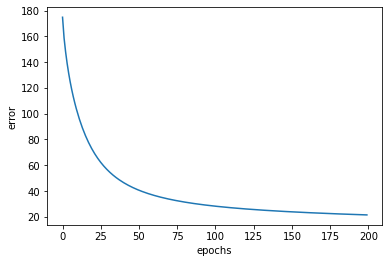

In [16]:
parameters = {}
costs = []
initialize_parameters(layers_dims)
learning(train_x, train_y, noOfTrainData, learning_rate=0.01, n_iterations=200)
print("Train Accuracy:", predict(train_x, train_y))
plot_cost()

In [17]:
print("Test Accuracy:", predict(test_x, test_y))

Test Accuracy: 92.85714285714286
